# Определение жанра композиции
## Описание задачи
Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
Данные:
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- music_genre - музыкальный жанр

План исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.
## Загрузка и анализ данных

In [1]:
#!pip install phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import re 
import seaborn as sns
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.stem import WordNetLemmatizer 
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('kaggle_music_genre_train.csv')

In [4]:
df.head(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [6]:
df.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


По данным отметим из необычного что id число с плавающей точкой, типы данных все корректные, пропуски в признаках key, mode, tempo

Посмотрим признаки по отдельности

In [7]:
df['instance_id'].duplicated().sum() # дубликатов по id нет

0

In [8]:
df['track_name'].value_counts() # видим что есть одинаковые названия, но id у всех разные

track_name
Home                          11
Diamonds                       7
Summertime                     7
Gravity                        6
Dreams                         6
                              ..
Bloody F8 (feat. Aimer)        1
Willy Wonka (feat. Offset)     1
Window Pain - Outro            1
Greatness                      1
Trouble (feat. MC Spyder)      1
Name: count, Length: 18643, dtype: int64

In [9]:
df['key'].value_counts() # тут у нас около 700 пропусков

key
G     2304
C     2149
C#    2125
D     2110
A     2013
F     1616
B     1522
E     1516
G#    1268
A#    1224
F#    1206
D#     606
Name: count, dtype: int64

In [10]:
df['key'] = df['key'].fillna('other')

In [11]:
df['mode'].value_counts() # этот признак имеет 500 пропусков.

mode
Major    12828
Minor     7060
Name: count, dtype: int64

In [12]:
df['tempo'].value_counts() # много уникальных значений и 400 пропусков

tempo
140.011    9
120.000    9
119.998    9
130.016    8
100.003    8
          ..
71.607     1
169.832    1
100.311    1
94.913     1
146.803    1
Name: count, Length: 15762, dtype: int64

In [13]:
df.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                   0
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [14]:
df['obtained_date'].value_counts() # этот признак нам никак не поможет

obtained_date
4-Apr    18435
3-Apr     1524
5-Apr      290
1-Apr      145
Name: count, dtype: int64

Я посомтрю как распределны наши данные по целевым признакам

In [15]:
grouped = df.groupby('music_genre')

distribution = grouped['acousticness'].median()

print(distribution.sort_values(ascending=False))

music_genre
Classical      0.96900
Jazz           0.51600
Blues          0.21050
Country        0.19050
Hip-Hop        0.10500
Rap            0.09605
Rock           0.07240
Anime          0.05190
Alternative    0.03160
Electronic     0.02640
Name: acousticness, dtype: float64


In [16]:
df.query('music_genre=="Jazz"')['acousticness'].quantile([.4, 0.95])

0.40    0.3712
0.95    0.9720
Name: acousticness, dtype: float64

Мы видим, что некоторые жанры по акустичности едва различимы, например те что 0.1 и меньше. С другой стороны Classical, Jazz, Blues имеют выраженные отличия от соседей. 

In [17]:
print(df['acousticness'].describe())
df['acousticness'].quantile([.05, 0.95])

count    20394.000000
mean         0.274783
std          0.321643
min          0.000000
25%          0.015200
50%          0.120000
75%          0.470000
max          0.996000
Name: acousticness, dtype: float64


0.05    0.000325
0.95    0.964000
Name: acousticness, dtype: float64

In [18]:
grouped = df.groupby('music_genre')

distribution = grouped['energy'].median()

print(distribution.sort_values(ascending=False))

music_genre
Anime          0.7980
Electronic     0.7705
Alternative    0.7500
Rock           0.7170
Country        0.6680
Hip-Hop        0.6520
Rap            0.6500
Blues          0.6350
Jazz           0.4720
Classical      0.1000
Name: energy, dtype: float64


In [19]:
print(df['energy'].describe())
df['energy'].quantile([.05, 0.95])

count    20394.000000
mean         0.625276
std          0.251238
min          0.001010
25%          0.470000
50%          0.666000
75%          0.830000
max          0.999000
Name: energy, dtype: float64


0.05    0.112
0.95    0.957
Name: energy, dtype: float64

In [20]:
grouped = df.groupby('music_genre')

distribution = grouped['loudness'].median()

print(distribution.sort_values(ascending=False))

music_genre
Anime          -5.6190
Alternative    -6.0350
Rap            -6.3385
Electronic     -6.4060
Rock           -6.4840
Country        -6.4990
Hip-Hop        -6.5830
Blues          -8.4175
Jazz          -10.4000
Classical     -21.9570
Name: loudness, dtype: float64


In [21]:
print(df['loudness'].describe())
df['loudness'].quantile([.05, 0.95])

count    20394.000000
mean        -8.552998
std          5.499917
min        -44.406000
25%        -10.255750
50%         -7.052000
75%         -5.054000
max          3.744000
Name: loudness, dtype: float64


0.05   -20.37845
0.95    -3.02265
Name: loudness, dtype: float64

In [22]:
grouped = df.groupby('music_genre')

distribution = grouped['instrumentalness'].median()

print(distribution.sort_values(ascending=False))

music_genre
Classical      0.837000
Electronic     0.178000
Jazz           0.135000
Blues          0.000971
Anime          0.000258
Alternative    0.000066
Rock           0.000049
Country        0.000001
Hip-Hop        0.000000
Rap            0.000000
Name: instrumentalness, dtype: float64


In [23]:
print(df['instrumentalness'].describe())
df['instrumentalness'].quantile([.05, 0.95])

count    20394.000000
mean         0.159989
std          0.306503
min          0.000000
25%          0.000000
50%          0.000144
75%          0.084475
max          0.996000
Name: instrumentalness, dtype: float64


0.05    0.000
0.95    0.898
Name: instrumentalness, dtype: float64

In [24]:
grouped = df.groupby('music_genre')

distribution = grouped['valence'].median()

print(distribution.sort_values(ascending=False))

music_genre
Blues          0.586
Country        0.531
Rock           0.518
Jazz           0.517
Hip-Hop        0.465
Rap            0.449
Anime          0.435
Alternative    0.434
Electronic     0.361
Classical      0.139
Name: valence, dtype: float64


In [25]:
print(df['valence'].describe())
df['instrumentalness'].quantile([.05, 0.95])

count    20394.000000
mean         0.464588
std          0.243387
min          0.000000
25%          0.272000
50%          0.457000
75%          0.653000
max          0.992000
Name: valence, dtype: float64


0.05    0.000
0.95    0.898
Name: instrumentalness, dtype: float64

In [26]:
grouped = df.groupby('music_genre')

distribution = grouped['danceability'].median()

print(distribution.sort_values(ascending=False))

music_genre
Hip-Hop        0.7380
Rap            0.7190
Electronic     0.6310
Jazz           0.5960
Country        0.5815
Rock           0.5470
Alternative    0.5450
Blues          0.5290
Anime          0.4830
Classical      0.2960
Name: danceability, dtype: float64


In [27]:
print(df['danceability'].describe())
df['danceability'].quantile([.05, 0.95])

count    20394.000000
mean         0.561983
std          0.171898
min          0.060000
25%          0.451000
50%          0.570000
75%          0.683000
max          0.978000
Name: danceability, dtype: float64


0.05    0.255
0.95    0.834
Name: danceability, dtype: float64

In [28]:
grouped = df.groupby('music_genre')

distribution = grouped['tempo'].median()

print(distribution.sort_values(ascending=False))

music_genre
Anime          128.0020
Electronic     126.0000
Country        121.9700
Rock           120.8400
Hip-Hop        120.1000
Alternative    120.0480
Rap            120.0200
Blues          119.1180
Jazz           105.3485
Classical       95.5235
Name: tempo, dtype: float64


In [29]:
print(df['tempo'].describe())
df['tempo'].quantile([.05, 0.95])

count    19952.000000
mean       120.942522
std         30.427590
min         34.765000
25%         95.921750
50%        120.012500
75%        141.966250
max        220.041000
Name: tempo, dtype: float64


0.05     76.5236
0.95    174.1340
Name: tempo, dtype: float64

In [30]:
grouped = df.groupby('music_genre')

distribution = grouped['liveness'].median()

print(distribution.sort_values(ascending=False))

music_genre
Blues          0.1410
Anime          0.1390
Hip-Hop        0.1370
Alternative    0.1350
Rap            0.1350
Country        0.1290
Electronic     0.1275
Rock           0.1270
Jazz           0.1160
Classical      0.1110
Name: liveness, dtype: float64


In [31]:
print(df['liveness'].describe())
df['liveness'].quantile([.05, 0.95])

count    20394.000000
mean         0.198540
std          0.166742
min          0.013600
25%          0.097300
50%          0.130000
75%          0.253000
max          1.000000
Name: liveness, dtype: float64


0.05    0.0624
0.95    0.5720
Name: liveness, dtype: float64

In [32]:
grouped = df.groupby('music_genre')

distribution = grouped['speechiness'].median()

print(distribution.sort_values(ascending=False))

music_genre
Hip-Hop        0.19600
Rap            0.16200
Electronic     0.05725
Alternative    0.05350
Anime          0.04560
Jazz           0.04380
Blues          0.04340
Classical      0.04320
Rock           0.03940
Country        0.03410
Name: speechiness, dtype: float64


In [33]:
print(df['speechiness'].describe())
df['speechiness'].quantile([.05, 0.95])

count    20394.000000
mean         0.091352
std          0.097735
min          0.022300
25%          0.035600
50%          0.049050
75%          0.095575
max          0.942000
Name: speechiness, dtype: float64


0.05    0.0278
0.95    0.3130
Name: speechiness, dtype: float64

In [34]:
grouped = df.groupby('music_genre')

distribution = grouped['duration_ms'].median()

print(distribution.sort_values(ascending=False))

music_genre
Classical      243173.0
Electronic     236800.0
Jazz           235467.0
Anime          231427.0
Blues          220789.0
Rock           220027.0
Alternative    219733.0
Rap            207573.5
Country        207305.0
Hip-Hop        206240.0
Name: duration_ms, dtype: float64


In [35]:
print(df['duration_ms'].describe())
df['duration_ms'].quantile([.1, 0.95])

count    2.039400e+04
mean     2.203754e+05
std      1.267283e+05
min     -1.000000e+00
25%      1.775170e+05
50%      2.195330e+05
75%      2.660000e+05
max      4.497994e+06
Name: duration_ms, dtype: float64


0.10     50208.60
0.95    393913.55
Name: duration_ms, dtype: float64

In [36]:
df['duration_ms'].median()

219533.0

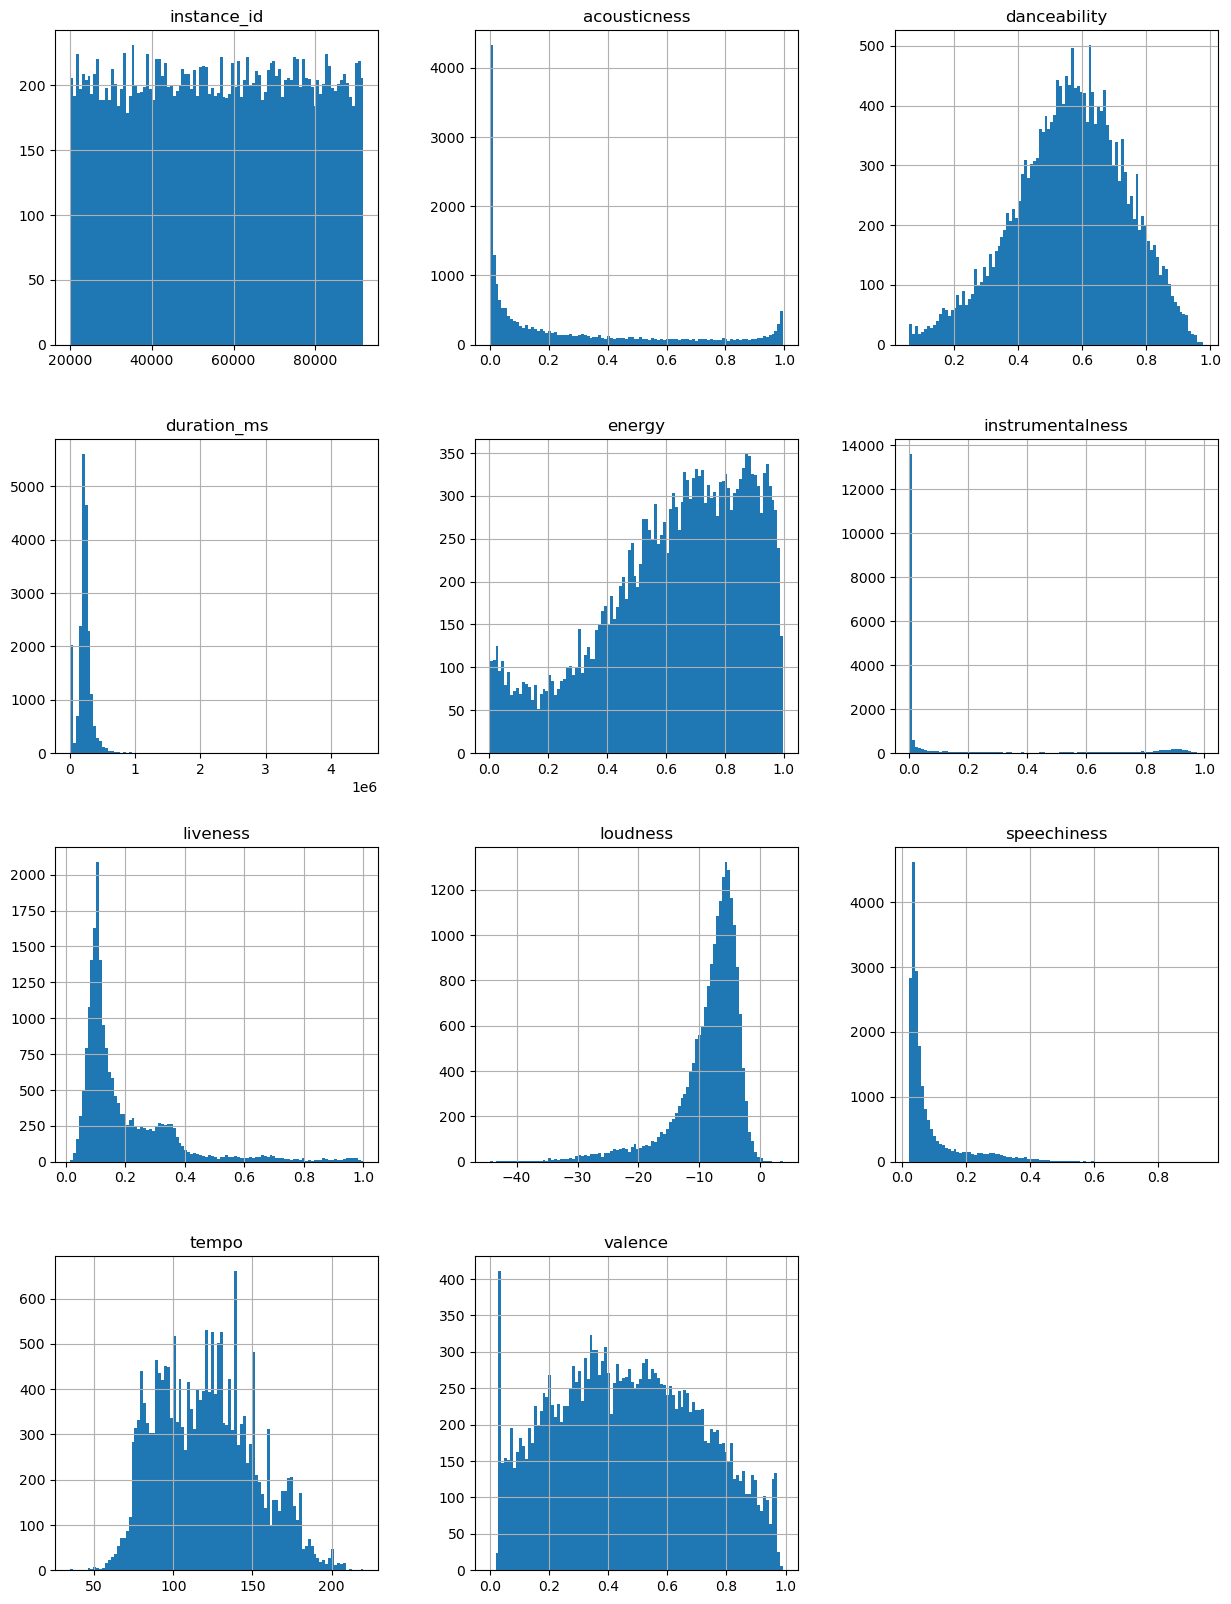

In [37]:
# визуально оценим распределение признаков
df.hist(figsize=(15, 20), bins=100)
plt.show()

Я посмотрел как распределены все признаки, в моем понимании самые неадекватные значения - это песни с очень маленьки значением длины трека, я заменю их на медианное значение.

In [38]:
duration_ms = df['duration_ms'].median()

def duration_ms_meadian(row):
    if row['duration_ms'] < 50208.60:
        return duration_ms
    else:
        return row['duration_ms']

df['duration_ms'] = df.apply(duration_ms_meadian, axis=1)

Во время анализа данных я обратил внимание, что часть названий имеют больше количество слов. Я полагаю, что например в классических композиция обычно указывают много слов, что позволяет мне попробовать создать признак.

In [39]:
# посчитаю длину строки для каждого названия как дополнительный признак
df['len_names'] = df['track_name'].apply(lambda x: len(x))

In [40]:
df['music_genre'].value_counts() # пропусков и аномалий нет

music_genre
Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: count, dtype: int64

Итого у нас 10 классов , нужно не забыть их разбить равномерно при построении тренировочной и валидационной выборки

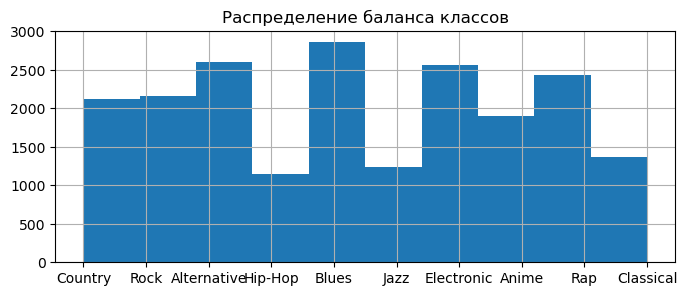

In [41]:
df['music_genre'].hist(bins=10,figsize=(8,3))
plt.title("Распределение баланса классов")
plt.show()

In [42]:
df.select_dtypes(exclude=['float64', 'int64']).columns # вызову список признаков для удобства перед оценкой корреляции

Index(['track_name', 'key', 'mode', 'obtained_date', 'music_genre'], dtype='object')

In [43]:
df.select_dtypes(include=['float64', 'int64']).columns

Index(['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'len_names'],
      dtype='object')

In [44]:
phik_overview = df[['key', 'mode','acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence','len_names', 'music_genre']].phik_matrix(interval_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'len_names'])

In [45]:
phik_overview

,key,mode,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,len_names,music_genre
key,1.000000,0.295871,0.097168,0.102511,0.033802,0.090606,0.033780,0.058493,0.083085,0.118245,0.037878,0.045502,0.024422,0.169033
mode,0.295871,1.000000,0.029099,0.103777,0.006100,0.033624,0.084661,0.028814,0.015795,0.104200,0.014283,0.058103,0.025666,0.296143
acousticness,0.097168,0.029099,1.000000,0.458491,0.121855,0.766657,0.441997,0.185885,0.709364,0.204106,0.336114,0.397133,0.427844,0.657653
danceability,0.102511,0.103777,0.458491,1.000000,0.163963,0.516204,0.342605,0.135120,0.483332,0.335523,0.407472,0.531502,0.287942,0.623224
duration_ms,0.033802,0.006100,0.121855,0.163963,1.000000,0.131828,0.152322,0.080106,0.155185,0.021524,0.088823,0.132436,0.147258,0.178421
energy,0.090606,0.033624,0.766657,0.516204,0.131828,1.000000,0.437427,0.256748,0.839273,0.239284,0.387013,0.478888,0.416870,0.669221
instrumentalness,0.033780,0.084661,0.441997,0.342605,0.152322,0.437427,1.000000,0.138175,0.498359,0.190934,0.218501,0.357175,0.226438,0.567686
liveness,0.058493,0.028814,0.185885,0.135120,0.080106,0.256748,0.138175,1.000000,0.199227,0.138512,0.084412,0.130656,0.119214,0.208943
loudness,0.083085,0.015795,0.709364,0.483332,0.155185,0.839273,0.498359,0.199227,1.000000,0.211301,0.357614,0.437069,0.462129,0.679369
speechiness,0.118245,0.104200,0.204106,0.335523,0.021524,0.239284,0.190934,0.138512,0.211301,1.000000,0.206596,0.119157,0.026536,0.498084


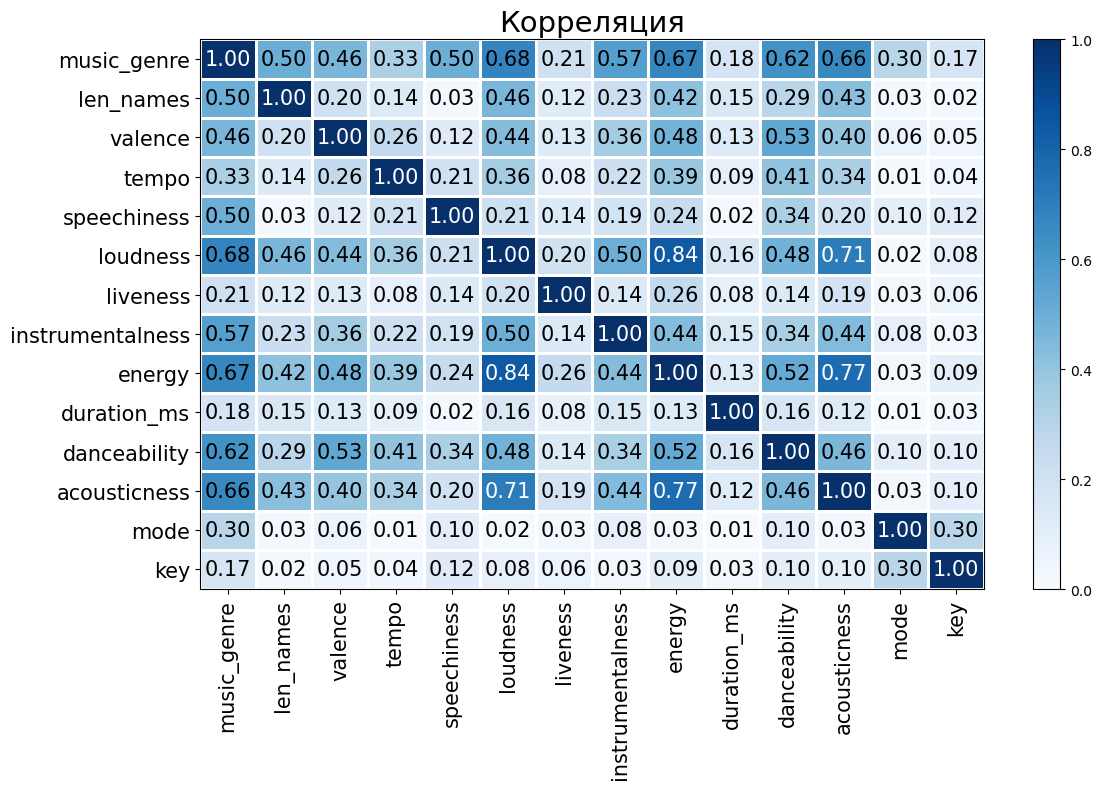

In [46]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'Корреляция', fontsize_factor=1.5,
                        figsize=(12,8))
plt.tight_layout()

Тепловая карта наглядно показывает зависимость признаков.

Я заполню порпуски в mode модой по key так как это единственный признак с которым он коллерует,а в tempo медианным значением по коррелирующим признакам

In [47]:
df.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                   0
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
len_names             0
dtype: int64

In [48]:
df['mode'] = df['mode'].fillna('other')

# создаем словарь соответствия моды каждой группе значений key
mode_mapping = df.groupby('key')['mode'].apply(lambda x: x.mode().values[0]).to_dict()

# заполняем пропущенные значения в столбце 'mode' на основе значений в столбце key
df['mode'] = df.apply(lambda row: mode_mapping[row['key']] if pd.isnull(row['mode']) else row['mode'], axis=1)

In [49]:
# заполняем пропуски в столбце 'tempo' с использованием медианного значения danceability, energy, acousticness
df['tempo'] = df['tempo'].fillna(df.groupby('danceability')['tempo'].transform('median'))
df['tempo'] = df['tempo'].fillna(df.groupby('energy')['tempo'].transform('median'))
df['tempo'] = df['tempo'].fillna(df.groupby('acousticness')['tempo'].transform('median'))

In [50]:
df.isnull().sum() # проверим что нет пропусков

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
len_names           0
dtype: int64

Между energy, acousticness, loudness есть мультиколлениарность, это может стать проблемой для линейной модели

## Подотовка данных и обучение модели

Я не буду брать instance_id, потому что это не информативный признак, obtained_date так как мы делаем продукт на будущее и там будет явно другие даты чем те 3 дня что нам предоставлены в датасете.

Сначала я обработаю названия песен. Я уберу лишние знаки, приведу к единому регистру и начальной формы слов. 

In [51]:
def clear_text(text): # создадим функцию для очистки текста от лишних символов
    clear_text = re.sub(r'[^a-zA-Z ]', ' ',text).lower()
    return " ".join(clear_text.split())

In [52]:
corpus = df['track_name']
clear_text(corpus[0]) # тестируем работу, все хорошо

'highwayman'

In [53]:
df['lemma_track_name'] = df['track_name'].apply(clear_text)
df.head(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,len_names,lemma_track_name
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country,10,highwayman
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock,21,toes across the floor
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative,21,first person on earth
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop,26,no te veo digital single
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative,15,chasing shadows


In [54]:
def get_wordnet_pos(text): # создадим функцию для применения POS тегов для преобразования слов в начальные формы
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([text])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [55]:
def lemmatize(text):  # создадим функцию лемматизации
    lemmatizer = WordNetLemmatizer() # объявим лемматизатор
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)] # применим лемматизацию к ранее очищенному тексту
    lemm_text = " ".join(lemm_list) # добавим пробелы
    
    return lemm_text

In [56]:
df['lemma_track_name'] = df['lemma_track_name'].apply(lemmatize) # изменим ранее созданную колонку
df.head(5) # теперь у нас есть колонка с исходным текстом и лемматизированным и очищенным

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,len_names,lemma_track_name
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country,10,highwayman
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock,21,toe across the floor
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative,21,first person on earth
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop,26,no te veo digital single
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative,15,chase shadow


In [57]:
# после обработки текста у меня появились пустые строки в основном Аниме. Я могу использовать это и создать дополнительный признак
df.query('lemma_track_name==""')['music_genre'].value_counts()

music_genre
Anime          366
Electronic      15
Alternative     10
Rap              7
Hip-Hop          5
Blues            5
Country          5
Classical        4
Rock             2
Jazz             1
Name: count, dtype: int64

In [58]:
# Задам категриальные значение для пометки если есть пропуск
df['after_lemma_empty'] = df['lemma_track_name'].apply(lambda x: 'Yes' if x=='' else 'No')

In [59]:
df.query('lemma_track_name==""').head(5) # проверка

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,len_names,lemma_track_name,after_lemma_empty
90,80943.0,ハイキュー!!,0.0200,0.5670,234360.0,0.585,0.8700,C,0.0679,-10.229,Major,0.0273,134.972,4-Apr,0.3710,Anime,7,,Yes
104,54759.0,ナウシカ・レクイエム(風の谷のナウシカより),0.9790,0.3670,196680.0,0.111,0.0295,F,0.1050,-14.490,Minor,0.0519,68.155,4-Apr,0.2050,Anime,22,,Yes
105,36240.0,メルシー,0.0702,0.5130,199189.0,0.964,0.0000,F,0.2860,-4.521,Minor,0.1690,95.542,4-Apr,0.5790,Anime,4,,Yes
119,51708.0,譲り葉塚,0.6370,0.4020,219533.0,0.281,0.0121,F,0.2080,-12.021,Major,0.0305,177.762,3-Apr,0.0835,Anime,4,,Yes
144,72127.0,後悔,0.9410,0.0967,169507.0,0.148,0.7190,C,0.1280,-18.953,Minor,0.0360,70.676,3-Apr,0.0580,Anime,2,,Yes


Я видел что в названиях песен чаще всего начальные формы слов, но я не могу быть уверен за все 20 000 строк

Приступим к тестированию моделей

In [60]:
targets = df['music_genre']
features = df[['lemma_track_name', 'key', 'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'len_names', 'after_lemma_empty']]

In [61]:
# определим слова в англ. языке которые не несут смысловой нагрузки, чтобы трасформер их не учитывал
stopwords = list(nltk_stopwords.words('english'))

Я попробую создать еще признаки и посмотрю что мне даст косинусное расстояние

In [62]:
selected_data = df[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
                      'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]

# масштабирование данных (нормализация)
selected_data = (selected_data - selected_data.mean()) / selected_data.std()

# преобразование столбца selected_data в двухмерный массив
selected_data_array = selected_data.values

# вычисление косинусного расстояния между всеми парами признаков
distances = pdist(selected_data_array, metric='cosine')

# преобразование distances в квадратную матрицу
dist_matrix = squareform(distances)

# вывод результатов
dist_matrix.shape

(20394, 20394)

Я тестировал множество признаков, в целом они не дают большого прироста на модели, я выбрал те которые лучше всего бустят модели

In [63]:
# создание нового столбца distances
df['distances_0'] = dist_matrix[0]
df['distances_2'] = dist_matrix[2]

# выбор нужных признаков
features = df[['lemma_track_name', 'key', 'mode', 'after_lemma_empty', 'acousticness', 'danceability', 'duration_ms', 'energy',
               'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'len_names', 'distances_0'
               ,'distances_2']]
targets = df['music_genre']

Я получу списки признаков чтобы мне было удобнее проводить тесты с моделями

In [64]:
oe_features = features.select_dtypes(include='object').columns.to_list()
print(oe_features) # категориальные признаки для OE

numeric_features = features.select_dtypes(exclude='object').columns.to_list()
print(numeric_features) # числовые признаки

['lemma_track_name', 'key', 'mode', 'after_lemma_empty']
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'len_names', 'distances_0', 'distances_2']


Разделим выборку на тренировочную и тестовую. 

In [65]:
features_train, features_test, target_train, target_test = train_test_split(features, targets, test_size=0.20, 
                                                                            random_state=12345, stratify=targets)
print(features_train.shape,features_test.shape)

(16315, 17) (4079, 17)


## Логистическая регрессия

В моделях машинного обучения я сразу буду применять конвейер с кросс валидацией для того чтобы обеспечить наиболее корректную трансформацию данных и получение наиболее точной метрики на кросс валидации. 

Для текстовых данных я передам в трасформет векторизатор, для числовых я передам скалер, а для категриальных OrdinalEncoder, так как категориальных признаков слишком много. 

Я пробовал убирать коллинеарные признаки, но это ухудшало метрику. 

In [66]:
column_transformer = make_column_transformer(
    (TfidfVectorizer(), 'lemma_track_name' ),
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(), ['key', 'mode', 'after_lemma_empty'], target_train),
    remainder='passthrough'
)

linear_reg = make_pipeline(
    column_transformer,
    LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=12345, max_iter=1200)
)

grid_space = {
    'logisticregression__C': [0.4],
}

grid = GridSearchCV(linear_reg, scoring='accuracy', param_grid=grid_space, cv=3, n_jobs=-1)

grid.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат accuracy: ', grid.best_score_)

Лучшие гиперпараметры:  {'logisticregression__C': 0.4}
Лучший результат accuracy:  0.4425373050392753


Я пробовал разные гиперпараметры, в итоге лучший вариант был такой.
Лучший результат accuracy:  0.44

Интересно что с применением стоп слов модель только хуже работает. 

## Случайный лес

In [67]:
%%time

column_transformer = make_column_transformer(
    (TfidfVectorizer(), 'lemma_track_name' ),
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(), ['key', 'mode', 'after_lemma_empty'], target_train),
    remainder='passthrough'
)
random_for = make_pipeline(
    column_transformer,
    RandomForestClassifier(random_state=12345)
)
grid_space = {
   'randomforestclassifier__max_depth':[x for x in range(80,91,5)], 
   'randomforestclassifier__n_estimators':[x for x in range(300,361,20)]
}

grid = GridSearchCV(random_for, scoring='accuracy', param_grid=grid_space, cv=2, n_jobs=-1)

grid.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат accuracy: ', grid.best_score_)

Лучшие гиперпараметры:  {'randomforestclassifier__max_depth': 90, 'randomforestclassifier__n_estimators': 360}
Лучший результат accuracy:  0.4861784329193175
CPU times: total: 2min 50s
Wall time: 4min 48s


Лучший результат accuracy:  0.49 для случайного леса. Я так же использовал разные гиперпараметры и подобрал эти как лучший вариант. 

## Градиентный бустинг над решающими деревьями CatBoost

Сначала я посмотрю как градиентный бустинг сам обработает признаки. Мы знаем, что он умеет самостоятельно работать с численными признаками и категориальными. В данной модели я уже проставил лучшие гиперпараметры, которые заведомом подобрал. 

In [68]:
%%time

cat_model = CatBoostClassifier(cat_features=['key', 'mode', 'after_lemma_empty'], task_type='GPU', random_state=12345)
grid_space = {
    'learning_rate':[0.1],
    'verbose':[False],
    'l2_leaf_reg': [2],
    'depth': [6],
    'iterations': [2700]
}

grid = GridSearchCV(cat_model, scoring='accuracy', param_grid=grid_space, cv=10)

grid.fit(features_train[['key', 'mode', 'after_lemma_empty', 'acousticness', 'danceability', 'duration_ms', 'energy', 
'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'len_names', 'distances_0', 'distances_2']], target_train)
catboost_accuracy = grid.best_score_

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат accuracy: ', catboost_accuracy)

Лучшие гиперпараметры:  {'depth': 6, 'iterations': 2700, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'verbose': False}
Лучший результат accuracy:  0.46552363971339605
CPU times: total: 16min 27s
Wall time: 4min 44s


Оценим важность признаков для лучшей модели:

In [69]:
best_model = grid.best_estimator_ # получение наилучшей модели

best_model.feature_importances_ # получение важности признаков

array([6.922275  , 3.05028221, 0.37188805, 7.78113719, 8.78841365,
       6.99897596, 5.86216631, 8.93741229, 5.76227996, 6.83216719,
       9.50457284, 5.42896421, 7.61774016, 5.68259961, 5.12206132,
       5.33706406])

In [70]:
importances = np.array([6.922275  , 3.05028221, 0.37188805, 7.78113719, 8.78841365,
       6.99897596, 5.86216631, 8.93741229, 5.76227996, 6.83216719,
       9.50457284, 5.42896421, 7.61774016, 5.68259961, 5.12206132,
       5.33706406])
feature_names = np.array(['key', 'mode', 'after_lemma_empty', 'acousticness', 'danceability', 'duration_ms', 'energy', 
'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'len_names', 'distances_0', 'distances_2'])

feature_importances = dict(zip(feature_names, importances)) # создание словаря с названиями признаков и их значениями важности

feature_importances

{'key': 7.46324723,
 'mode': 1.53329931,
 'after_lemma_empty': 0.36722972,
 'acousticness': 7.59478633,
 'danceability': 8.92213178,
 'duration_ms': 7.12052424,
 'energy': 6.20755959,
 'instrumentalness': 9.09876623,
 'liveness': 5.83429755,
 'loudness': 6.83918834,
 'speechiness': 9.54579045,
 'tempo': 5.4048219,
 'valence': 7.6118903,
 'len_names': 6.01649021,
 'distances_0': 5.04976037,
 'distances_2': 5.39021647}

Мы видим что важность распределена довольно равномерно и нет каких то наиболее сильных признаков. Кроме того искусственные признаки показывают хорошее влияние по сравнению с другими. 

Я намеренно оценивал силу признаков на лучшей модели катубст отдельно, так как при подключении текста веса признаков уходят в каждое значение слов названий треков и метрика становится бесполезной. 

In [71]:
%%time

column_transformer = make_column_transformer(
    (TfidfVectorizer(), 'lemma_track_name' ),
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(), ['key', 'mode', 'after_lemma_empty'], target_train),
    remainder='passthrough'
)
cat_model = make_pipeline(
    column_transformer,
    CatBoostClassifier(task_type='GPU', random_state=12345)
)
grid_space = {
    'catboostclassifier__learning_rate':[0.1],
    'catboostclassifier__verbose':[False],
    'catboostclassifier__l2_leaf_reg': [2],
    'catboostclassifier__depth': [6],
    'catboostclassifier__iterations': [2700]
}

grid = GridSearchCV(cat_model, scoring='accuracy', param_grid=grid_space, cv=10)

grid.fit(features_train, target_train)
catboost_accuracy = grid.best_score_

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат accuracy: ', catboost_accuracy)

Лучшие гиперпараметры:  {'catboostclassifier__depth': 6, 'catboostclassifier__iterations': 2700, 'catboostclassifier__l2_leaf_reg': 2, 'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__verbose': False}
Лучший результат accuracy:  0.5046271834914223
CPU times: total: 12min 43s
Wall time: 5min 17s


Градиентный бустинг показал наилучшую эффективность с результатом в accuracy 0.51 и это лучший результат.

Можем приступить к тестированию. 

## Тестовые данные

Посмотрим результат на тестовых данных

In [72]:
predictions = grid.best_estimator_.predict(features_test)

In [73]:
accuracy_score(target_test, predictions)

0.49987742093650406

Таким образом мы получаем результат accuracy 0.5 для тестовой выборки и можем считать этот результат успешным для текущего набора данных. 

## Общий вывод

Перед нами стояла задача разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Для достижения поставленной цели я следовал следующему плану исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

Сначала мы загрузили и просмотрели данные. Я осмотрел в признаки по отдельности и оценил распределние каждого. В данных были пропуски и выбросы.

Далее я приступил к предобработке данных. Я посмотрел как распределены все признаки, я пришел к выводу, что самые неадекватные значения, это песни с очень маленьки значением длины трека, я заменил их на медианное значение. Во время анализа данных я обратил внимание, что часть названий имеют больше количество слов. Я полагаю, что например в классических композиция обычно указывают много слов, поэтому я создал новый признак по длинне знаков в имени. Затем я построил матрицу корреляций, чтобы посомтреть какие зависимости у признаков. Матрица показала что в целом признаки не сильно зависимы от целевого, но есть несколько ключевых. Я заполнил порпуски в mode модой по key так как это единственный признак с которым он коллерует,а в tempo медианным значением по коррелирующим признакам. Заполнил пропуски в столбце 'tempo' с использованием медианного значения danceability, energy, acousticness. Таким образом я устранил все пропущенные значения.

Далее я сформировал гипотизу что возможно названия каким то образом влияют на жанр. Поэтому я решил провести лемматизацию и провел операции по преобразованию слов названий песен в вектора. Во время этого преобразования я использовал библиотеку английского языка, поэтому во многих строках где раньше были иероглифы образовались пропуски. Таким образом я получил новый признак который давал сильную метку на Anime. Так же в поиске как найти еще признаки я провел инженеринг с косинусным расстоянием наиболее сильных признаков. Таким образом я создал еще нельсколько признаков.

Я проверил данные на мультиколлениарность в моделях машинного обучения, но отрасывание признаков ухудшало скор.

На этапе машинного обучения я принял решение что буду работать с логистической регрессией, случайным лесом и градиентным бустингом над решающим лесом. Для того чтобы выполнить наиболее качественный анализ я использовал конвейеры, а так же кросс валидацию. Я получил следующие результаты после подбора гиперпараметров:
- лигистическая регрессия accuracy: 0.44
- случайный лес accuracy: 0.49
- catboost accuracy: 0.51

Так же я получил наиболее важные признаки для лучшей модели и сделал вывод, что важность распределена достаточно равномерно. И так же я могу отметить что искуственные признаки показывают одни из лучших результатов, что говорит о пользе работы. 

На тестовой выборке я получил результат accuracy 0.5, таким образом могу считать, что успешно выполнил задание. 